# Evaluate evoked LFP response by optogenetic stimulations

### Import recordings

Load packages

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from IPython.display import display
from ipyfilechooser import FileChooser
from scipy.stats import zscore
import json
import matplotlib.cm as cm
import IPython
import ast

%matplotlib widget

In [2]:
#Load LFP coordinates 
notebook_path = Path("/".join(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]))
Channels = f'{notebook_path.parent}/_LFP_coordinates_of_all_mice.csv'
all_LFPcoordinates = pd.read_csv(Channels, index_col=0)

Choose OpenEphys folder

In [3]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    dpath = "//10.69.168.1/crnldata/forgetting/"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Go inside the folder containing the LFP raw file</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\AHCR40-Vert\AHCR40_109_Vert2025-02-06_…

Load LFPs data, TTL, timestamps

In [4]:
folder_base = Path(dpath) 
miceIDflipped=[]

if Path(f'{folder_base}\continuousDS.npy').exists(): # prefer loading downsample file over original file
    print('continuousDS.npy file')
    LFPfile=Path(f'{folder_base}\continuousDS.npy')
    All = np.load(LFPfile, mmap_mode= 'r')
    samplerate=1000 
    numchannel=All.shape[1]
    filepath = Path(os.path.join(folder_base.parent.parent, f'structure.oebin'))
    if filepath.exists():    
        with open(filepath) as f:
            metadata = json.load(f)
        rec_ch_list=np.array([int(''.join(c for c in metadata['continuous'][0]['channels'][x]['channel_name'] if c.isdigit()))-1 for x in range(0, len(metadata['continuous'][0]['channels']))] )
        print('Metadata found')
    else:
        samplerate=1000 
        numchannel=32
        rec_ch_list=np.arange(0,numchannel,1)
        print('No metadata found')
    # Load LFPs timestamps 
    for file_pathTS in folder_base.parent.parent.glob('**/continuous/*/timeStampsDS.npy'):
        print('LFPs timestamps file found')
        LFPtimestamps = np.load(file_pathTS)  
    # Check if headstages were accidentally flipped & you already corrected it
    if Path(f"{folder_base}MiceID_if_flipped_headstage.txt").exists():
        with open(Path(f"{folder_base}\MiceID_if_flipped_headstage.txt"), "r") as file:
            miceIDflipped = ast.literal_eval(file.read())
elif Path(f'{folder_base}\continuous.dat').exists():
    print('continuous.dat file')
    LFPfile = Path(f'{folder_base}\continuous.dat')
    DataRec = np.fromfile(LFPfile, dtype="int16")
    filepath = Path(os.path.join(folder_base.parent.parent, f'structure.oebin'))
    with open(filepath) as f:
        metadata = json.load(f)
    samplerate=metadata['continuous'][0]['sample_rate']  
    numchannel=metadata['continuous'][0]['num_channels'] 
    rec_ch_list=np.array([int(''.join(c for c in metadata['continuous'][0]['channels'][x]['channel_name'] if c.isdigit()))-1 for x in range(0, len(metadata['continuous'][0]['channels']))])
    All = DataRec.reshape(-1,numchannel)
    print('Metadata found')
    # Load LFPs timestamps 
    for file_pathTS in folder_base.parent.parent.glob('**/continuous/*/timeStamps.npy'):
        print('LFPs timestamps file found')
        LFPtimestamps = np.load(file_pathTS)  
else: 
    print('no LFPs file found')

print('sample rate =', samplerate, 'Hz')
print(numchannel, 'channels recorded')
print(round(All.shape[0]/samplerate/60), 'min of recording')

continuousDS.npy file
Metadata found
LFPs timestamps file found
sample rate = 1000 Hz
32 channels recorded
8 min of recording


In [5]:
nb_decimal=3 # 4 = 0.1ms precision / 3 = 1ms precision

# Load TTLs
TTL_Opto_duration=[]
for file_pathTTL in folder_base.parent.parent.glob('**/TTL/timeStamps.npy'):
    print('TTL opto file = ', file_pathTTL)
    TTL_Opto_o = np.load(file_pathTTL)
    TTL_Opto_duration =[round(TTL_Opto_o[i+1] - TTL_Opto_o[i],nb_decimal) for i in range(len(TTL_Opto_o) - 1)[::2]]
    TTL_Opto= TTL_Opto_o[::2] # remove the TTL for laser OFF, only keep TTL for laser ON. CAUTION /!/ works only if it started with a TTL for laser ON
    print(TTL_Opto.shape[0], 'opto stimulations')

TTL opto file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\Vert\AHAD02_05_Vert2025-02-18_10-07-34EPSP50\Record Node 106\experiment1\recording1\events\OE_FPGA_Acquisition_Board-105.Rhythm Data\TTL\timeStamps.npy
98 opto stimulations


Downsample LFP data to 1kHz if needed & save it

In [6]:
if samplerate > 1000:
    new_sampling_rate = 1000 # Hz
    Nmber_points = int(np.shape(All)[0] * new_sampling_rate / samplerate)
    AllDS=signal.resample(All, Nmber_points, axis = 0)
    LFPtimestampsDS=LFPtimestamps[::samplerate/new_sampling_rate][:-1]
    samplerate=new_sampling_rate
    np.save(f'{LFPfile.parent}/continuousDS.npy', AllDS)
    np.save(f'{file_pathTS.parent}/timeStampsDS.npy', LFPtimestampsDS)
    All=AllDS
    LFPtimestamps=LFPtimestampsDS
# eventually delete original files to gain space

Identify LFP electrodes

In [7]:
mouse = []
pos_mice = []
for mouse_name in all_LFPcoordinates.index:
    if mouse_name in LFPfile.__str__():
        mouse.append(mouse_name)
        pos_mice.append(LFPfile.__str__().find(mouse_name)) 
mouse = [x for _, x in sorted(zip(pos_mice, mouse))] # sort mouse in the same order as they appear in the path

if len(mouse) > 1: # found multiple mouse name in the path
    if max(rec_ch_list) <= 31: # no channels superior to 32, so only one mouse recorded
        id = 0 # choose 0 to see the first mouse name found, 1 the second, etc
        ID = 0
        print(f"/!\ Mutliple mice name found in the path but only mouse recorded = {mouse}. The n°{id+1} was choosen automatically = {mouse[id]}.")
        mouse = mouse[id]
    else:
        ID = 0 # choose 0 to see the first mouse recorded, 1 the second, 2 the third, 3 the fourth (only 4 mice can be recorded at the same time)
        print(f"/!\ Mutliple mice recorded at the same time = {mouse}. The n°{ID+1} was choosen automatically = {mouse[ID]}.")
        mouse = mouse[ID] 
elif len(mouse) == 1: # found only one mouse name in the path
    ID = 0
    mouse = mouse[ID]
    
all_LFPcoordinates= all_LFPcoordinates.astype(str)
for region in all_LFPcoordinates.loc[mouse].index:
    locals()[f'{region}_0']=[]
    locals()[f'{region}_1']=[]
    locals()[f'{region}_0ch']=[]
    locals()[f'{region}_1ch']=[]

RecordedArea=[]
ChoosenChannels=[]
combined=[]
inverted_chs = np.concatenate([range(16,32,1), range(0,16,1)], axis=0)
if mouse:
    rec_ch_list_ID=rec_ch_list-ID*32
    rec_ch_list_mouse=[value for value in rec_ch_list_ID if 0 <= value <= 31]
    if str(ID) in miceIDflipped:
        rec_ch_list_mouse = inverted_chs[rec_ch_list_mouse]  
    for col, rec_ch in enumerate(rec_ch_list_mouse):
        for idx, LFPcoord_str in enumerate(all_LFPcoordinates.loc[mouse]):
            region=all_LFPcoordinates.loc[mouse].index[idx]
            if LFPcoord_str!='nan' and region != 'EMG':
                LFPcoord = LFPcoord_str.split('_')[:2] # only take into account the 2 first of electrode of that region 
                num_ch=np.where(str(rec_ch) == np.array(LFPcoord))[0]
                if len(num_ch)>0:
                    region=all_LFPcoordinates.loc[mouse].index[idx]
                    LFP=locals()[f'{region}_0']
                    if len(LFP)>0:
                        LFP= All[:,col+np.argmax(rec_ch_list_ID>=0)] 
                        locals()[f'{region}_1']=LFP
                        locals()[f'{region}_1ch']=rec_ch
                    else:
                        LFP= All[:,col+np.argmax(rec_ch_list_ID>=0)] 
                        locals()[f'{region}_0']=LFP
                        locals()[f'{region}_0ch']=rec_ch
                    break
                continue
    
    for region in all_LFPcoordinates.loc[mouse].index:
        for n in range(0,2,1):
            LFP=locals()[f'{region}_{n}']
            LFP_ch=locals()[f'{region}_{n}ch']
            if len(LFP)>0:
                combined=zscore(LFP[:,np.newaxis]) if len(combined)==0 else np.append(combined, zscore(LFP[:,np.newaxis]), axis=1)
                RecordedArea.append(f'{region}_{n}') 
                ChoosenChannels.append(LFP_ch) 
else:
    print("/!\ No mouse name found in the path OR in the csv file '_LFP_coordinates_of_all_mice.csv'")
    mouse='' # fill mouse name
    RecordedArea=['EMG','S1','PFC','CA1'] 
    EMG=All[:,0]
    S1=All[:,0]-All[:,0]
    combined=np.stack([zscore(EMG), zscore(S1)], axis=1)

print(mouse)
print(RecordedArea)
print(ChoosenChannels) 

Vert
['S1_0', 'S1_1', 'PFC_0', 'PFC_1', 'CA1_0', 'CA1_1', 'oPFC_0', 'oPFC_1', 'EnthC_0', 'EnthC_1', 'RH_0', 'RH_1']
[13, 15, 5, 7, 27, 29, 9, 11, 17, 19, 1, 3]


Check TTL durations

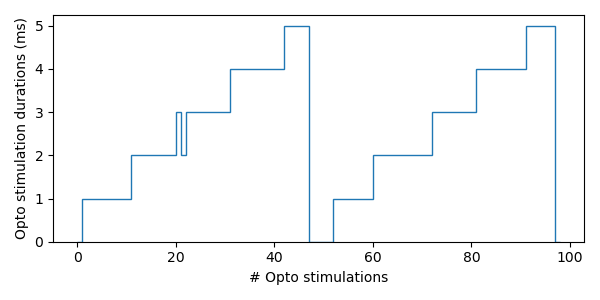

In [8]:
plt.close('all')
plt.figure(figsize=(6, 3))
plt.stairs(np.array(TTL_Opto_duration)*1000)
plt.xlabel('# Opto stimulations')
plt.ylabel('Opto stimulation durations (ms)')
plt.tight_layout()
plt.show()

### Get response of each brain region

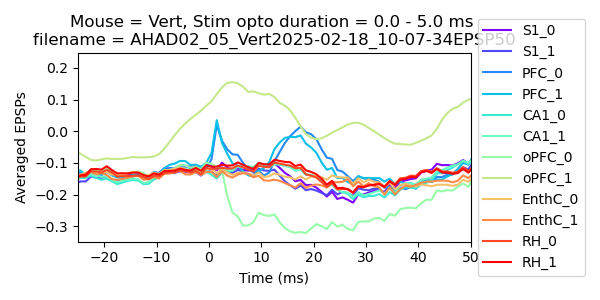

In [9]:
AllEPSPs=[]
for ttl in TTL_Opto:   
    idx = (np.abs(LFPtimestamps - ttl)).argmin() # find the closest LFP timestamps to the TTL
    AllEPSPs.append(combined[idx-round(0.5*samplerate):idx+round(0.5*samplerate), :]) #500 ms before and after TTL

plt.close()
plt.figure(figsize=(6, 3))
time_axis = np.linspace(-500, 500, np.shape(AllEPSPs)[1]) 
mEPSPs=np.mean(AllEPSPs, axis=0)
colors = cm.rainbow(np.linspace(0, 1, np.shape(mEPSPs)[1]))
for i in np.arange(0,np.shape(AllEPSPs)[2]):
    plt.plot(time_axis, mEPSPs[:,i], label=f'{RecordedArea[i]}', color=colors[i])
plt.xlabel("Time (ms)")
plt.ylabel("Averaged EPSPs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=1)
plt.subplots_adjust(right=.5)
plt.xlim([-25, 50])
plt.title(f'Mouse = {mouse}, Stim opto duration = {np.unique(TTL_Opto_duration)[0]*1000} - {np.round(np.unique(TTL_Opto_duration)[-1]*1000,2)} ms \nfilename = {folder_base.parts[-6]}', fontsize=12) # Change to indicate where is located that LFP
plt.tight_layout()
plt.show()

### Get response for one brain region

Choose brain region

In [10]:
Selected_region='PFC_0' # to change
SelectedLFP=locals()[Selected_region]

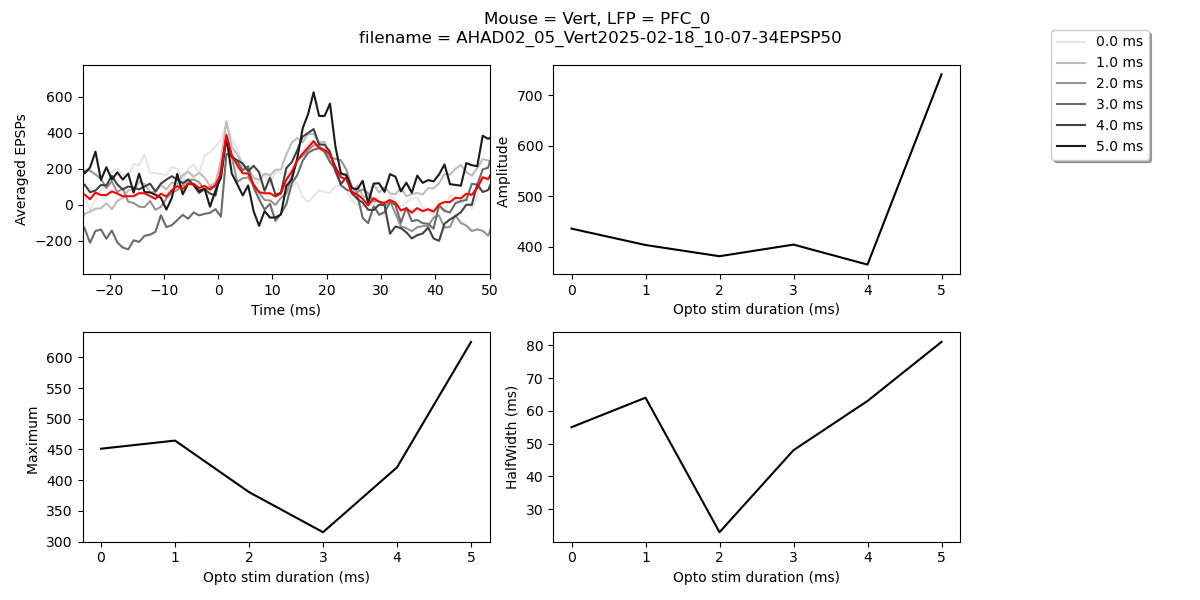

In [11]:
nb_differentStim=len(np.unique(TTL_Opto_duration)) # how many different opto stim are performed in the arduino protocol (here a loop of 19 stim with different durations)
DurStim=np.unique(TTL_Opto_duration)*1000 # durations of each unique stim (from 1 ms to 20 ms with a step of 1)

halfdurEPSP=0.1 #sec
analyseWindow= 0.025 #sec post stim

AllStim={}
for i, ttl  in enumerate(TTL_Opto):
    idx = (np.abs(LFPtimestamps - ttl)).argmin() # find the closest LFP timestamps to the TTL    
    if str(TTL_Opto_duration[i]*1000) in AllStim:
        AllStim[str(TTL_Opto_duration[i]*1000) ]=pd.concat([AllStim[str(TTL_Opto_duration[i]*1000) ],pd.DataFrame(SelectedLFP[idx-round(halfdurEPSP*samplerate):idx+round(halfdurEPSP*samplerate)])],axis=1)
    else:
        AllStim[str(TTL_Opto_duration[i]*1000) ]=pd.DataFrame(SelectedLFP[idx-round(halfdurEPSP*samplerate):idx+round(halfdurEPSP*samplerate)])
   
AllStim_sorted = dict(sorted(AllStim.items()))
meanAllStim= pd.DataFrame([np.mean(AllStim_sorted[key], axis=1) for key in AllStim_sorted.keys()]).T
meanAllStim= pd.DataFrame([meanAllStim[key]-np.mean(meanAllStim[key][int((halfdurEPSP*samplerate)-(halfdurEPSP*samplerate)):int(halfdurEPSP*samplerate)]) for key in meanAllStim.columns]).T
meanAllStim.columns=DurStim #convert columns names in ms

"""                         
Amplitude=[]
Max=[]
HalfMaxWidth=[]
for i in meanAllStim.columns:
    y=meanAllStim[i][round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)]
    peaks, properties = signal.find_peaks(y, height=min(y), prominence=0)
    if len(peaks) > 0:
        widths, width_heights, left_ips, right_ips = signal.peak_widths(y, peaks, rel_height=0.5)
        biggest_peak_idx = np.argmax(properties["peak_heights"])
        biggest_peak = peaks[biggest_peak_idx]
        half_width = widths[biggest_peak_idx] / 2
        Amplitude.append(properties["prominences"][biggest_peak_idx])
        Max.append(properties["peak_heights"][biggest_peak_idx])
        HalfMaxWidth.append(half_width)
    else:
        Amplitude.append(np.nan)
        Max.append(np.nan)
        HalfMaxWidth.append(np.nan)
"""
Amplitude=meanAllStim[round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)].max()-meanAllStim[round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)].min()
Max=meanAllStim[round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)].max()
HalfMaxWidth = [((np.abs(meanAllStim[i][meanAllStim[i][meanAllStim[i]==Max[i]].index[0]:] - Max[i]/2)).argmin() -round(halfdurEPSP*samplerate) + meanAllStim[i][meanAllStim[i]==Max[i]].index[0])/samplerate*1000 for i in meanAllStim.columns]

# Plot
plt.close()
fig, axs = plt.subplots(2,2, figsize=(12,6))
fig.suptitle(f'Mouse = {mouse}, LFP = {Selected_region} \nfilename = {folder_base.parts[-6]}', fontsize=12) # Change to indicate where is located that LFP

time_axis = np.linspace(-halfdurEPSP*1000, halfdurEPSP*1000, meanAllStim.shape[0]) 
grey_shades = np.linspace(0.9, 0.1, len(meanAllStim.columns)) 
for i, col in enumerate(meanAllStim.columns):
    axs[0,0].plot(time_axis, meanAllStim[col], color=(grey_shades[i], grey_shades[i], grey_shades[i]), label=f'{round(col,4)} ms')
axs[0,0].plot(time_axis, np.mean(meanAllStim, axis= 1), color='red')
axs[0,0].set(xlabel="Time (ms)", ylabel="Averaged EPSPs")
#axs[0,0].set(ylim=(-750, 1000))
axs[0,0].set(xlim=(-25, 50))

axs[0,1].plot(DurStim,Amplitude, 'k')
axs[0,1].set(xlabel="Opto stim duration (ms)", ylabel="Amplitude ")

axs[1,0].plot(DurStim,Max, 'k')
axs[1,0].set(xlabel="Opto stim duration (ms)", ylabel="Maximum ")

axs[1,1].plot(DurStim, HalfMaxWidth, 'k')
axs[1,1].set(xlabel="Opto stim duration (ms)", ylabel="HalfWidth (ms)")

plt.tight_layout()
axs[0,0].legend(loc='upper center', bbox_to_anchor=(2.5, 1.2),
          fancybox=True, shadow=True, ncol=max(int(nb_differentStim/18), 1))
plt.subplots_adjust(right=.8)  
plt.show()

### Flip omnetics headstage

Run the cell bellow if you believe omnetic headstage was reverted for this mouse during this session (if you run it twice it will go back to the initial configuration). /!\ You need to recreate LFP stereotrodes afterward

In [ ]:
inverted_chs = np.concatenate([range(16,32,1), range(0,16,1)], axis=0)
Allflipped = All.copy()
rec_ch_list_ID = rec_ch_list-ID*32
rec_ch_list_mouse = [value for value in rec_ch_list_ID if 0 <= value <= 31]
i = np.argmax(rec_ch_list_ID>=0)
AR = np.stack([rec_ch_list_mouse, inverted_chs[rec_ch_list_mouse], np.arange(i, i+len(rec_ch_list_mouse))], axis=1)
AR_sort = AR[AR[:, 1].argsort()]
for n,r in enumerate(AR_sort[:,2]):
    Allflipped[:,r] = All[:,n+i]
    print('column n°', r, 'becomes column n°', n+i)
All = Allflipped
if len(miceIDflipped)>0 and str(ID) not in miceIDflipped:
    miceIDflipped.append(str(ID)) # this mouseID is also flipped 
elif len(miceIDflipped)>0 and str(ID) in miceIDflipped:
    miceIDflipped = [s for s in miceIDflipped if s != str(ID)] # this mouseID is actually not flipped 
else:
    miceIDflipped = str(ID) # this mouseID is flipped 

Save if you're now sure that the omnetic headstage was reverted for this mouse during this recording

In [ ]:
with open(Path(f"{folder_base}\MiceID_if_flipped_headstage.txt"), "w") as file:
    file.write(str(miceIDflipped)) # otherwise rec_ch won't be recognized in all_LFP_coordinates

# save a reverted version that will be loaded in priority 
if samplerate <= 1000:
    np.save(f'{LFPfile.parent}/continuousDS.npy', All) 
else:
    new_sampling_rate = 1000 # Hz
    Nmber_points = int(np.shape(All)[0] * new_sampling_rate / samplerate)
    AllDS = signal.resample(All, Nmber_points, axis = 0)
    LFPtimestampsDS = LFPtimestamps[::int(samplerate/new_sampling_rate)][:-1]
    samplerate = new_sampling_rate
    np.save(f'{LFPfile.parent}/continuousDS.npy', AllDS)
    np.save(f'{file_pathTS.parent}/timeStampsDS.npy', LFPtimestampsDS)
    All = AllDS
    LFPtimestamps = LFPtimestampsDS